In [7]:
from datetime import datetime, timedelta
import requests
import pandas as pd

# Function to convert a date to a UNIX timestamp at midnight UTC
def date_to_unix_midnight(date_str):
    return int(datetime.strptime(date_str, '%Y-%m-%d').replace(hour=0, minute=0, second=0).timestamp())

# Function to retrieve arrival and departure data
def get_flights(airport, begin, end):
    arrivals_url = "https://opensky-network.org/api/flights/arrival"
    departures_url = "https://opensky-network.org/api/flights/departure"
    
  # Retrieve arrivals
    arrivals_params = {'airport': airport, 'begin': begin, 'end': end}
    arrivals_response = requests.get(arrivals_url, params=arrivals_params)
    if arrivals_response.status_code == 200:
        arrivals = arrivals_response.json()
    else:
        print(f"Error for Retrieving arrivals : {arrivals_response.status_code} - {arrivals_response.text}")
        arrivals = []
    
    # Retrieve departures
    departures_params = {'airport': airport, 'begin': begin, 'end': end}
    departures_response = requests.get(departures_url, params=departures_params)
    if departures_response.status_code == 200:
        departures = departures_response.json()
    else:
        print(f"Error retrieving departures: {departures_response.status_code} - {departures_response.text}")
        departures = []
    
    return arrivals, departures

# Function to retrieve data for a 30 day period in 7 day segments
def get_flights_for_30_days(airport, start_date, end_date):
    current_start = start_date
    all_arrivals = []
    all_departures = []

    while current_start < end_date:
        current_end = min(current_start + timedelta(days=7), end_date)  # Limit on max 7 days
        
        begin = int(current_start.timestamp())
        end = int(current_end.timestamp())
        
        print(f"Data recovery from {current_start} to {current_end}")
        
        # Retrieve arrivals and departures data for the period
        arrivals, departures = get_flights(airport, begin, end)
        all_arrivals.extend(arrivals)
        all_departures.extend(departures)
        
      # Move to the next period
        current_start = current_end

    return all_arrivals, all_departures

# Set the period (January 1 to January 30, 2023)
start_date = datetime(2023, 1, 1)
end_date = datetime(2023, 1, 30)
airport = 'KJFK'

arrivals, departures = get_flights_for_30_days(airport, start_date, end_date)

# Show results
print(f"Arrivals : {len(arrivals)}flights recovered")
print(f"Départures : {len(departures)} flights recovered")

# Convert to DataFrame and save as CSV
arrivals_df = pd.DataFrame(arrivals)
departures_df = pd.DataFrame(departures)



In [9]:

arrivals_df.to_csv('../data/arrivals_jan2023.csv')
arrivals_df.to_csv('../data/departures_jan2023.csv')


In [57]:
from datetime import datetime, timedelta
import requests
import pandas as pd


#Read CSV File
arrivals_df = pd.read_csv('../data/arrivals_jan2023.csv')
departures_df = pd.read_csv('../data/departures_jan2023.csv')
print(arrivals_df.head())
print ()


   icao24   firstSeen estDepartureAirport    lastSeen estArrivalAirport  \
0  ac8217  1673138964                KSLC  1673153857              KJFK   
1  a7beea  1673136490                 NaN  1673153849              KJFK   
2  06a141  1673126602                EHBK  1673153695              KJFK   
3  ac89f7  1673141133                 NaN  1673153493              KJFK   
4  aca99c  1673136321                KSEA  1673153489              KJFK   

   callsign  estDepartureAirportHorizDistance  \
0  DAL380                              3259.0   
1  GLG7392                                NaN   
2  QTR8183                              742.0   
3  JBU1110                                NaN   
4  DAL374                               914.0   

   estDepartureAirportVertDistance  estArrivalAirportHorizDistance  \
0                            281.0                            1105   
1                              NaN                            2869   
2                            121.0          

In [56]:
# Get data size
arrivals_shape = arrivals_df.shape
departures_shape = departures_df.shape

print(f"Size of arrival data: {arrivals_shape}")
print(f"Size of departure date : {departures_shape}")

Size of arrival data: (16614, 12)
Size of departure date : (15898, 12)


In [55]:

# STEP 2: Data cleaning
# Identifying missing values
print("Missing values ​​in arrivals data:")
print(arrivals_df.isnull().sum())

print("\nMissing values ​​in the starting data :")
print(departures_df.isnull().sum())

#1. Remove lines with missing 'callsign'
arrivals_df_clean = arrivals_df.dropna(subset=['callsign']).copy()
departures_df_clean = departures_df.dropna(subset=['callsign']).copy()

#2. Fill the 'estDepartureAirport' and 'estArrivalAirport' columns with 'Unknown'
arrivals_df_clean.loc[:, 'estDepartureAirport'] = arrivals_df_clean['estDepartureAirport'].fillna('Unknown')
departures_df_clean.loc[:, 'estArrivalAirport'] = departures_df_clean['estArrivalAirport'].fillna('Unknown')

#3. Imputation of missing distances with the median
arrivals_df_clean.loc[:, 'estDepartureAirportHorizDistance'] = arrivals_df_clean['estDepartureAirportHorizDistance'].fillna(arrivals_df_clean['estDepartureAirportHorizDistance'].median())
arrivals_df_clean.loc[:, 'estDepartureAirportVertDistance'] = arrivals_df_clean['estDepartureAirportVertDistance'].fillna(arrivals_df_clean['estDepartureAirportVertDistance'].median())

departures_df_clean.loc[:, 'estArrivalAirportHorizDistance'] = departures_df_clean['estArrivalAirportHorizDistance'].fillna(departures_df_clean['estArrivalAirportHorizDistance'].median())
departures_df_clean.loc[:, 'estArrivalAirportVertDistance'] = departures_df_clean['estArrivalAirportVertDistance'].fillna(departures_df_clean['estArrivalAirportVertDistance'].median())

#4. Checking for missing values ​​after cleaning
print("\nMissing values ​​remaining after cleaning (arrivals):")
print(arrivals_df_clean.isnull().sum())

print("\nMissing values ​​remaining after cleaning (départures) :")
print(departures_df_clean.isnull().sum())

# Save cleaned data to CSV files
arrivals_df_clean.to_csv('../data/arrivals_jan2023_clean.csv', index=False)
departures_df_clean.to_csv('../data/departures_jan2023_clean.csv', index=False)
print("\Cleaned data saved successfully.")


Missing values ​​in arrivals data:
icao24                                 0
firstSeen                              0
estDepartureAirport                 3370
lastSeen                               0
estArrivalAirport                      0
callsign                               3
estDepartureAirportHorizDistance    3370
estDepartureAirportVertDistance     3370
estArrivalAirportHorizDistance         0
estArrivalAirportVertDistance          0
departureAirportCandidatesCount        0
arrivalAirportCandidatesCount          0
dtype: int64

Missing values ​​in the starting data :
icao24                                 0
firstSeen                              0
estDepartureAirport                    0
lastSeen                               0
estArrivalAirport                   2121
callsign                               3
estDepartureAirportHorizDistance       0
estDepartureAirportVertDistance        0
estArrivalAirportHorizDistance      2121
estArrivalAirportVertDistance       2121
departure

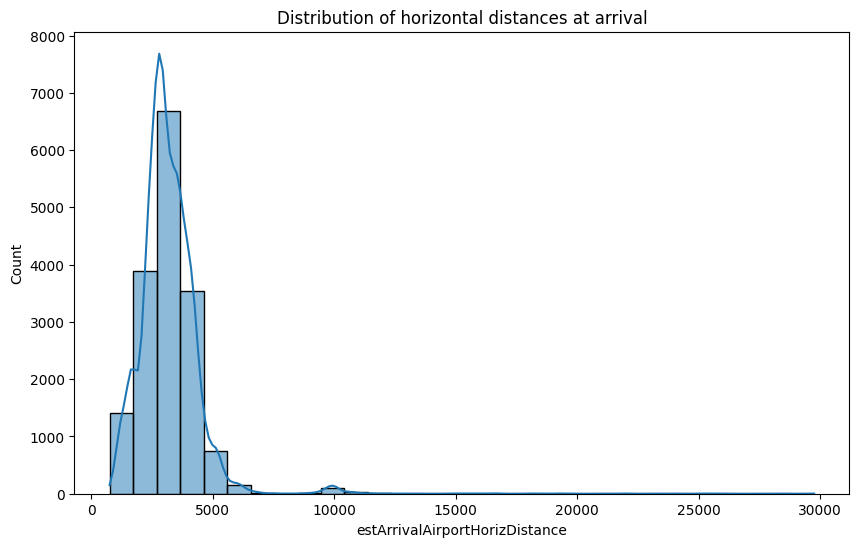

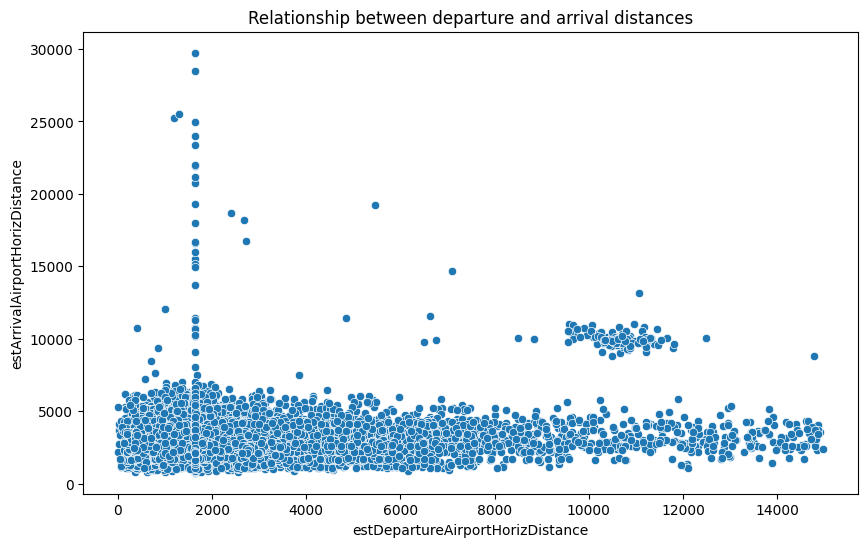

In [14]:
# EDA 

import seaborn as sns
import matplotlib.pyplot as plt

# Distribution of arrival distances
plt.figure(figsize=(10,6))
sns.histplot(arrivals_df_clean['estArrivalAirportHorizDistance'], bins=30, kde=True)
plt.title('Distribution of horizontal distances at arrival')
plt.show()

# Scatter plot of start and finish distances
plt.figure(figsize=(10,6))
sns.scatterplot(x='estDepartureAirportHorizDistance', y='estArrivalAirportHorizDistance', data=arrivals_df_clean)
plt.title('Relationship between departure and arrival distances')
plt.show()


In [15]:
#Feature engineering

# Calculate the flight time in seconds
arrivals_df_clean['flight_duration'] = arrivals_df_clean['lastSeen'] - arrivals_df_clean['firstSeen']
departures_df_clean['flight_duration'] = departures_df_clean['lastSeen'] - departures_df_clean['firstSeen']

# Converting timestamps to days of the week
arrivals_df_clean['weekday'] = pd.to_datetime(arrivals_df_clean['firstSeen'], unit='s').dt.weekday
departures_df_clean['weekday'] = pd.to_datetime(departures_df_clean['firstSeen'], unit='s').dt.weekday
# Set a threshold to consider a flight delayed (e.g. median)
flight_duration_threshold = arrivals_df_clean['flight_duration'].median()

# Create a column 'delayed' where True indicates a delay (flight longer than the median)
arrivals_df_clean['delayed'] = arrivals_df_clean['flight_duration'] > flight_duration_threshold

# Check new columns
print(arrivals_df_clean[['flight_duration', 'delayed']].head())

   flight_duration  delayed
0            14893     True
1            17359     True
2            27093     True
3            12360     True
4            17168     True


In [16]:
# Create a new feature for the difference between the start and finish distances
arrivals_df_clean['distance_diff'] = arrivals_df_clean['estArrivalAirportHorizDistance'] - arrivals_df_clean['estDepartureAirportHorizDistance']

# Extract time of day from timestamp 'firstSeen'
arrivals_df_clean['hour_of_day'] = pd.to_datetime(arrivals_df_clean['firstSeen'], unit='s').dt.hour

# Create an interaction between 'hour_of_day' and 'weekday'
arrivals_df_clean['hour_weekday_interaction'] = arrivals_df_clean['hour_of_day'] * arrivals_df_clean['weekday']

# Check new columns
print(arrivals_df_clean[['distance_diff', 'hour_of_day', 'hour_weekday_interaction']].head())

   distance_diff  hour_of_day  hour_weekday_interaction
0        -2154.0            0                         0
1         1242.0            0                         0
2         1997.0           21                       105
3         2108.0            1                         6
4          407.0            0                         0


In [18]:
# ADD ANOTHER DATA 

import requests

# Visual Crossing API Key
api_key = 'AMZW2KNXFLDJF9R5WMUTHMWHQ'

# Location
location = 'Paris,France'

# 1 month period (from January 1, 2023 to January 30, 2023)
start_date = '2023-01-01'
end_date = '2023-01-30'

# Visual Crossing API URL for a time period
url = f"https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/timeline/{location}/{start_date}/{end_date}?key={api_key}"

# Make the query to retrieve the weather data
response = requests.get(url)

# Verifying the response
if response.status_code == 200:
    data = response.json()
    print("Données récupérées avec succès")
    

  # show first entries
    for day in data['days']:
        print(f"Date: {day['datetime']}, Température max: {day['tempmax']}°C, Température min: {day['tempmin']}°C")
else:
    print(f"Erreur {response.status_code}: {response.text}")


Données récupérées avec succès
Date: 2023-01-01, Température max: 58.8°C, Température min: 52.5°C
Date: 2023-01-02, Température max: 57.6°C, Température min: 45.1°C
Date: 2023-01-03, Température max: 49.2°C, Température min: 42.0°C
Date: 2023-01-04, Température max: 56.3°C, Température min: 49.6°C
Date: 2023-01-05, Température max: 56.5°C, Température min: 52.4°C
Date: 2023-01-06, Température max: 55.7°C, Température min: 50.7°C
Date: 2023-01-07, Température max: 51.7°C, Température min: 45.7°C
Date: 2023-01-08, Température max: 51.7°C, Température min: 44.9°C
Date: 2023-01-09, Température max: 48.2°C, Température min: 42.3°C
Date: 2023-01-10, Température max: 52.8°C, Température min: 39.5°C
Date: 2023-01-11, Température max: 53.7°C, Température min: 49.0°C
Date: 2023-01-12, Température max: 53.0°C, Température min: 48.6°C
Date: 2023-01-13, Température max: 52.1°C, Température min: 45.6°C
Date: 2023-01-14, Température max: 54.1°C, Température min: 46.1°C
Date: 2023-01-15, Température m

In [52]:


# Convert weather data to pandas DataFrame
weather_data = pd.DataFrame(data['days'])
# Save data to a CSV file
weather_data.to_csv('../data/weather_data_1mois.csv', index=False)
print("Weather data saved in 'weather_data_1mois.csv'")

Weather data saved in 'weather_data_1mois.csv'


In [53]:
print(weather_data.head())

     datetime  datetimeEpoch  tempmax  tempmin  temp  feelslikemax  \
0  2023-01-01     1672527600     58.8     52.5  55.5          58.8   
1  2023-01-02     1672614000     57.6     45.1  51.3          57.6   
2  2023-01-03     1672700400     49.2     42.0  45.7          45.0   
3  2023-01-04     1672786800     56.3     49.6  53.1          56.3   
4  2023-01-05     1672873200     56.5     52.4  54.6          56.5   

   feelslikemin  feelslike   dew  humidity  ...  sunriseEpoch    sunset  \
0          52.5       55.5  47.2      74.5  ...    1672559053  17:04:11   
1          42.0       50.6  46.7      84.7  ...    1672645450  17:05:11   
2          38.7       41.6  43.6      92.4  ...    1672731845  17:06:13   
3          44.4       52.6  50.3      90.4  ...    1672818236  17:07:17   
4          52.4       54.6  50.1      84.9  ...    1672904624  17:08:24   

   sunsetEpoch moonphase              conditions  \
0   1672589051      0.31          Rain, Overcast   
1   1672675511      0.35

In [54]:
# Fahrenheit -> Celsius conversion function
def fahrenheit_to_celsius(fahrenheit):
    return (fahrenheit - 32) * 5.0/9.0
# Converting temperature columns to Celsius
weather_data['tempmax'] = weather_data['tempmax'].apply(fahrenheit_to_celsius)
weather_data['tempmin'] = weather_data['tempmin'].apply(fahrenheit_to_celsius)
weather_data['temp'] = weather_data['temp'].apply(fahrenheit_to_celsius)

# Check for changes
print(weather_data[['datetime', 'tempmax', 'tempmin', 'temp']].head())


     datetime    tempmax    tempmin       temp
0  2023-01-01  14.888889  11.388889  13.055556
1  2023-01-02  14.222222   7.277778  10.722222
2  2023-01-03   9.555556   5.555556   7.611111
3  2023-01-04  13.500000   9.777778  11.722222
4  2023-01-05  13.611111  11.333333  12.555556


In [50]:
# Select relevant columns
columns_to_keep = ['datetime', 'tempmax', 'tempmin', 'humidity', 'conditions', 'description']
selected_weather_data = weather_data[columns_to_keep]
# Show selected data
print(selected_weather_data.head())


# Save selected data to a CSV file
selected_weather_data.to_csv('../data/selected_weather_data.csv', index=False)
print("Selected weather data saved in '../data/selected_weather_data.csv'")


     datetime    tempmax    tempmin  humidity              conditions  \
0  2023-01-01  14.888889  11.388889      74.5          Rain, Overcast   
1  2023-01-02  14.222222   7.277778      84.7  Rain, Partially cloudy   
2  2023-01-03   9.555556   5.555556      92.4  Rain, Partially cloudy   
3  2023-01-04  13.500000   9.777778      90.4          Rain, Overcast   
4  2023-01-05  13.611111  11.333333      84.9          Rain, Overcast   

                                         description  
0  Cloudy skies throughout the day with afternoon...  
1  Partly cloudy throughout the day with a chance...  
2        Partly cloudy throughout the day with rain.  
3         Cloudy skies throughout the day with rain.  
4         Cloudy skies throughout the day with rain.  
Selected weather data saved in '../data/selected_weather_data.csv'


In [49]:
# DATA MERGE

# Load cleaned flight data (arrivals and departures)
arrivals_df_clean = pd.read_csv('../data/arrivals_jan2023_clean.csv')
departures_df_clean = pd.read_csv('../data/departures_jan2023_clean.csv')
# Load cleaned weather data
weather_data = pd.read_csv('../data/selected_weather_data.csv')

# Associate arrival or departure date with weather data
# Here we use the 'datetime' column in weather_data and 'lastSeen' in arrivals_df_clean (or 'firstSeen' for departures)

# Convert date columns to the same format
arrivals_df_clean['date'] = pd.to_datetime(arrivals_df_clean['lastSeen'], unit='s').dt.date
departures_df_clean['date'] = pd.to_datetime(departures_df_clean['firstSeen'], unit='s').dt.date
weather_data['datetime'] = pd.to_datetime(weather_data['datetime']).dt.date

# Merge weather data with arrivals and departures data
arrivals_with_weather = pd.merge(arrivals_df_clean, weather_data, left_on='date', right_on='datetime', how='left')
departures_with_weather = pd.merge(departures_df_clean, weather_data, left_on='date', right_on='datetime', how='left')

# Show some results to check
print(arrivals_with_weather.head())
print(departures_with_weather.head())

# Save results to CSV files
arrivals_with_weather.to_csv('../data/arrivals_with_weather.csv', index=False)
departures_with_weather.to_csv('../data/departures_with_weather.csv', index=False)

print("Flight data with associated weather saved.")


   icao24   firstSeen estDepartureAirport    lastSeen estArrivalAirport  \
0  ac8217  1673138964                KSLC  1673153857              KJFK   
1  a7beea  1673136490             Unknown  1673153849              KJFK   
2  06a141  1673126602                EHBK  1673153695              KJFK   
3  ac89f7  1673141133             Unknown  1673153493              KJFK   
4  aca99c  1673136321                KSEA  1673153489              KJFK   

   callsign  estDepartureAirportHorizDistance  \
0  DAL380                              3259.0   
1  GLG7392                             1627.0   
2  QTR8183                              742.0   
3  JBU1110                             1627.0   
4  DAL374                               914.0   

   estDepartureAirportVertDistance  estArrivalAirportHorizDistance  \
0                            281.0                            1105   
1                            133.0                            2869   
2                            121.0          

In [24]:

# Get data size
arrivals_shape = arrivals_with_weather.shape
departures_shape = departures_with_weather.shape

print(f"Size of arrival data : {arrivals_shape}")
print(f"Size of departure data : {departures_shape}")


Size of arrival data : (16611, 19)
Size of departure data : (15895, 19)


In [47]:

# Load flight data with associated weather
arrivals_with_weather = pd.read_csv('../data/arrivals_with_weather.csv')
departures_with_weather = pd.read_csv('../data/departures_with_weather.csv')

# Fill missing values ​​with an interpolation method or default values
arrivals_with_weather.fillna(method='ffill', inplace=True) 
departures_with_weather.fillna(method='ffill', inplace=True)



# Show a preview of the results to check
print(arrivals_with_weather.head())
print(departures_with_weather.head())

#Save files after handling missing values
arrivals_with_weather.to_csv('../data/arrivals_with_weather_cleaned.csv', index=False)
departures_with_weather.to_csv('../data/departures_with_weather_cleaned.csv', index=False)

print("Cleaned flight data with associated weather saved.")


   icao24   firstSeen estDepartureAirport    lastSeen estArrivalAirport  \
0  ac8217  1673138964                KSLC  1673153857              KJFK   
1  a7beea  1673136490             Unknown  1673153849              KJFK   
2  06a141  1673126602                EHBK  1673153695              KJFK   
3  ac89f7  1673141133             Unknown  1673153493              KJFK   
4  aca99c  1673136321                KSEA  1673153489              KJFK   

   callsign  estDepartureAirportHorizDistance  \
0  DAL380                              3259.0   
1  GLG7392                             1627.0   
2  QTR8183                              742.0   
3  JBU1110                             1627.0   
4  DAL374                               914.0   

   estDepartureAirportVertDistance  estArrivalAirportHorizDistance  \
0                            281.0                            1105   
1                            133.0                            2869   
2                            121.0          

In [60]:

# Merge the two DataFrames on a common column (eg: 'icao24')
merged_data = pd.merge(arrivals_with_weather, departures_with_weather, on='icao24', suffixes=('_arrival', '_departure'))

# Check the result
print("\nMerged data:")
print(merged_data.head())


Merged data:
   icao24  firstSeen_arrival estDepartureAirport_arrival  lastSeen_arrival  \
0  ac8217         1673138964                        KSLC        1673153857   
1  ac8217         1673138964                        KSLC        1673153857   
2  ac8217         1673138964                        KSLC        1673153857   
3  ac8217         1673138964                        KSLC        1673153857   
4  ac8217         1673138964                        KSLC        1673153857   

  estArrivalAirport_arrival callsign_arrival  \
0                      KJFK         DAL380     
1                      KJFK         DAL380     
2                      KJFK         DAL380     
3                      KJFK         DAL380     
4                      KJFK         DAL380     

   estDepartureAirportHorizDistance_arrival  \
0                                    3259.0   
1                                    3259.0   
2                                    3259.0   
3                                    325

In [61]:
# Save the merged file if you merged the data
merged_data.to_csv('../data/merged_flight_data.csv', index=False)

In [30]:
# Check for duplicates
duplicates = merged_data.duplicated()
print(f"Number of duplicates : {duplicates.sum()}")

# Remove duplicates 
merged_data_clean = merged_data.drop_duplicates()

Number of duplicates : 7945


In [31]:
# Create a copy of the original DataFrame
merged_data_clean = merged_data_clean.copy()

# Calculate flight duration using
merged_data_clean.loc[:, 'flight_duration'] = merged_data_clean['lastSeen_arrival'] - merged_data_clean['firstSeen_arrival']

# Replace missing values ​​with 0 explicitly
merged_data_clean.loc[:, 'flight_duration'] = merged_data_clean['flight_duration'].fillna(0)



In [62]:
# Converting timestamps to days of the week
merged_data_clean['weekday'] = pd.to_datetime(departures_df_clean['firstSeen'], unit='s').dt.weekday

# Set a threshold to consider a flight as delayed (e.g. the median)
flight_duration_threshold = merged_data_clean['flight_duration'].median()
# Create a column 'delayed' where True indicates a delay (flight longer than the median)
merged_data_clean['delayed'] = merged_data_clean['flight_duration'] > flight_duration_threshold

# Check new columns
print(merged_data_clean[['flight_duration', 'delayed']].head())

   flight_duration  delayed
0            14893     True
1            14893     True
2            14893     True
3            14893     True
4            14893     True


In [63]:
# Added weather features relevant to prediction
features = ['tempmax_arrival', 'tempmin_arrival', 'humidity_arrival', 'conditions_arrival',
            'tempmax_departure', 'tempmin_departure', 'humidity_departure', 'conditions_departure',
            'flight_duration', 'weekday']
# Data preparation for modeling
X = merged_data_clean[features]
y = merged_data_clean['delayed']  # Target: if the flight is delayed
# Display the first lines of the processed data
print(merged_data_clean[['flight_duration', 'delayed', 'tempmax_arrival', 'tempmin_arrival', 'humidity_arrival']].head())

   flight_duration  delayed  tempmax_arrival  tempmin_arrival  \
0            14893     True        10.944444         7.166667   
1            14893     True        10.944444         7.166667   
2            14893     True        10.944444         7.166667   
3            14893     True        10.944444         7.166667   
4            14893     True        10.944444         7.166667   

   humidity_arrival  
0              83.1  
1              83.1  
2              83.1  
3              83.1  
4              83.1  


In [64]:
print(merged_data_clean[['flight_duration', 'delayed','tempmin_arrival', 'humidity_arrival','conditions_arrival',
            'tempmax_departure', 'tempmin_departure', 'humidity_departure', 'conditions_departure']].head())

   flight_duration  delayed  tempmin_arrival  humidity_arrival  \
0            14893     True         7.166667              83.1   
1            14893     True         7.166667              83.1   
2            14893     True         7.166667              83.1   
3            14893     True         7.166667              83.1   
4            14893     True         7.166667              83.1   

       conditions_arrival  tempmax_departure  tempmin_departure  \
0  Rain, Partially cloudy          13.166667          10.388889   
1  Rain, Partially cloudy          13.166667          10.388889   
2  Rain, Partially cloudy          13.611111          11.333333   
3  Rain, Partially cloudy           9.555556           5.555556   
4  Rain, Partially cloudy          14.888889          11.388889   

   humidity_departure    conditions_departure  
0                83.5                Overcast  
1                83.5                Overcast  
2                84.9          Rain, Overcast  
3       

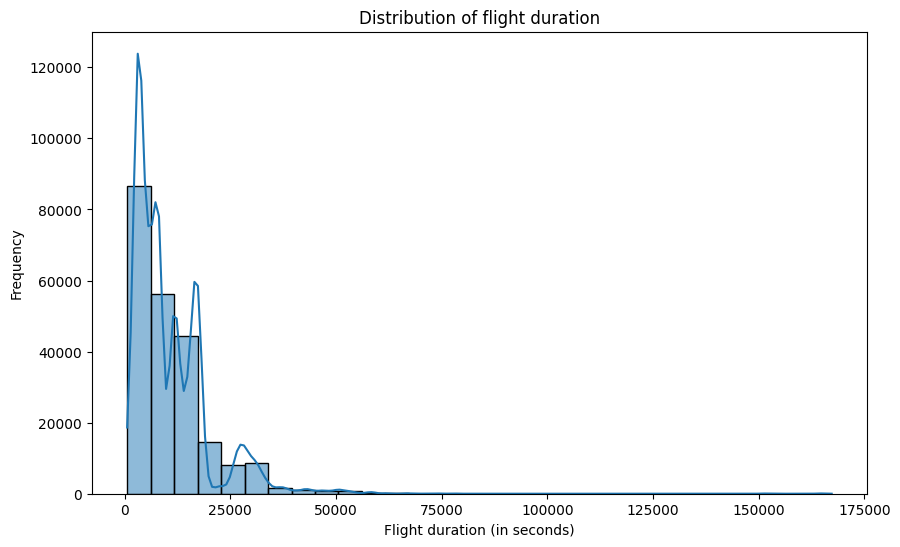

In [65]:
import seaborn as sns
import matplotlib.pyplot as plt

# Distribution of flight duration
plt.figure(figsize=(10, 6))
sns.histplot(merged_data_clean['flight_duration'], bins=30, kde=True)
plt.title('Distribution of flight duration')
plt.xlabel('Flight duration (in seconds)')
plt.ylabel('Frequency')
plt.show()


False    111700
True     111682
Name: delayed, dtype: int64


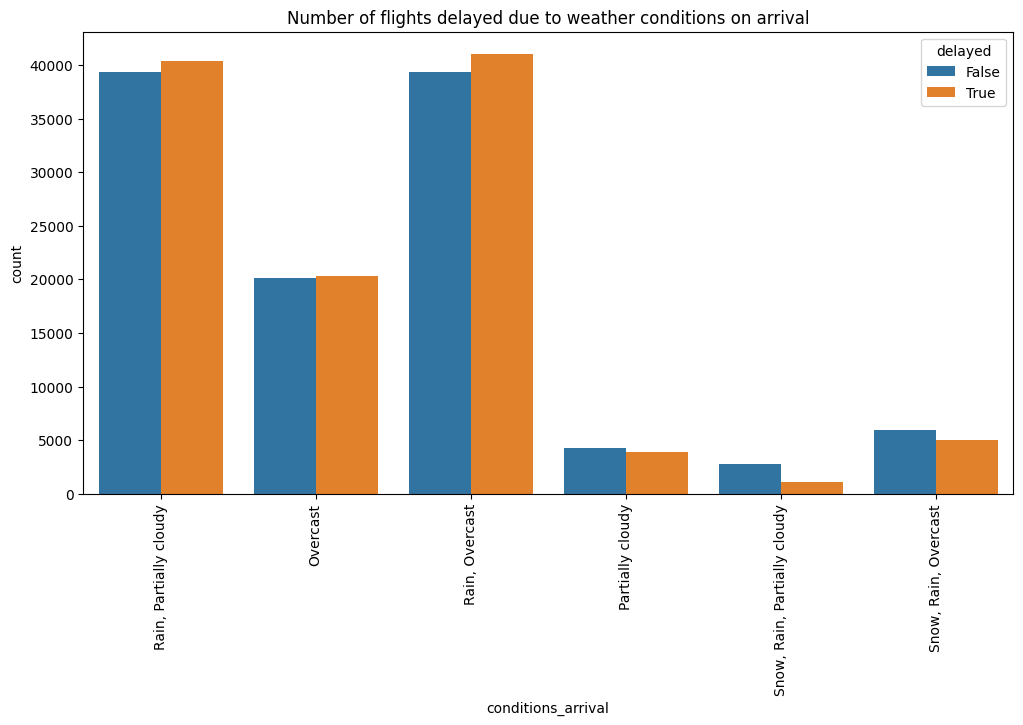

In [66]:
#ANALYSIS OF DELAYS

# Counting delayed and on-time flights
print(merged_data_clean['delayed'].value_counts())

# Graph of delays by weather condition
plt.figure(figsize=(12, 6))
sns.countplot(x='conditions_arrival', hue='delayed', data=merged_data_clean)
plt.xticks(rotation=90)
plt.title('Number of flights delayed due to weather conditions on arrival')
plt.show()


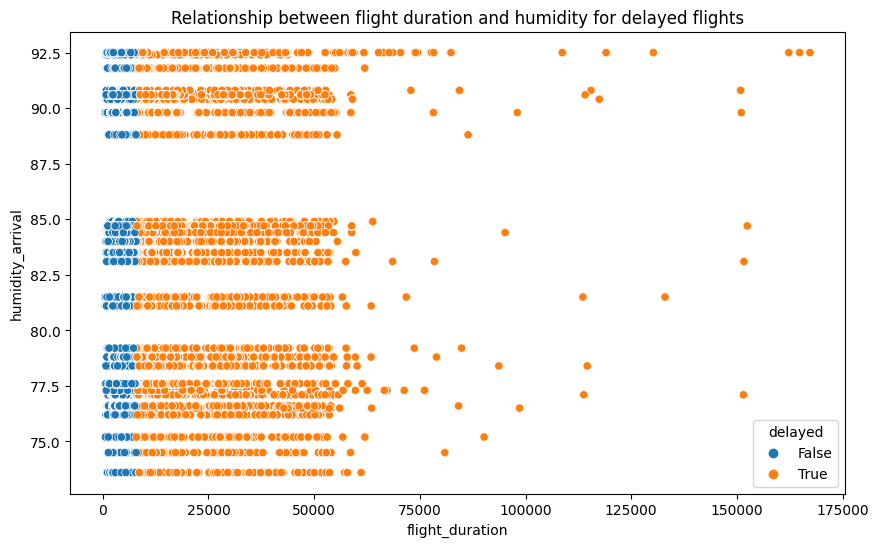

In [67]:
# ANALYSIS OF RELATIONSHIPS BETWEEN VARIABLES

# Scatter Chart: Flight Duration vs Delay
plt.figure(figsize=(10, 6))
sns.scatterplot(x='flight_duration', y='humidity_arrival', hue='delayed', data=merged_data_clean)
plt.title('Relationship between flight duration and humidity for delayed flights')
plt.show()

In [68]:
# MODEL

from sklearn.model_selection import train_test_split

# First divide into 80% (training + validation) and 20% (final test)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Then divide X_train_val again to get 70% for training and 10% for validation
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.125, random_state=42)

print(f"Train size: {X_train.shape}")
print(f"Validation size: {X_val.shape}")
print(f"Test size: {X_test.shape}")

Train size: (156366, 10)
Validation size: (22339, 10)
Test size: (44677, 10)


In [69]:
# Save datasets to CSV files
X_train.to_csv('../data/X_train.csv', index=False)
X_val.to_csv('../data/X_val.csv', index=False)
X_test.to_csv('../data/X_test.csv', index=False)

# Also save targets (y)
y_train.to_csv('../data/y_train.csv', index=False)
y_val.to_csv('../data/y_val.csv', index=False)
y_test.to_csv('../data/y_test.csv', index=False)



In [71]:

# SVM MODEL 
import os
import joblib


from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report


# Load Data
X_train = pd.read_csv('../data/X_train.csv')
X_test = pd.read_csv('../data/X_test.csv')
y_train = pd.read_csv('../data/y_train.csv')
y_test = pd.read_csv('../data/y_test.csv')




# columns present in X_train
categorical_columns = ['conditions_arrival', 'conditions_departure']  
continuous_columns = ['tempmax_arrival', 'tempmin_arrival', 'humidity_arrival',
                      'tempmax_departure', 'tempmin_departure', 'humidity_departure',
                      'flight_duration', 'weekday']  


label_encoders = {}

# Loop over each categorical column to create and adjust encoder
for col in categorical_columns:
    if col in X_train.columns:
        label_encoders[col] = LabelEncoder()  # Creates a separate encoder for each column
        # Adjust encoder with drive data
        X_train[col] = label_encoders[col].fit_transform(X_train[col].astype(str))
        # Transform test data with adjusted encoder
        X_test[col] = label_encoders[col].transform(X_test[col].astype(str))

# Save each encoder for future use
#for col, encoder in label_encoders.items():
   # joblib.dump(encoder, f'{col}_label_encoder.pkl')  # Save each encoder with its adjusted classes


# Imputation of missing values (if any)
imputer = SimpleImputer(strategy='mean') 
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Convert imputed data to DataFrame to access columns by name
X_train_imputed = pd.DataFrame(X_train_imputed, columns=X_train.columns)
X_test_imputed = pd.DataFrame(X_test_imputed, columns=X_test.columns)

# Data normalization for numeric columns
scaler = StandardScaler()
X_train_imputed[continuous_columns] = scaler.fit_transform(X_train_imputed[continuous_columns])
X_test_imputed[continuous_columns] = scaler.transform(X_test_imputed[continuous_columns])

# If you need to use all standardized data
X_train_scaled = X_train_imputed.copy()
X_test_scaled = X_test_imputed.copy()



# Train SVM model
svm_model = SVC(kernel='rbf', C=1.0, gamma='scale')
svm_model.fit(X_train_scaled, y_train.values.ravel())  # .ravel() to convert in 1D array


y_pred = svm_model.predict(X_test_scaled)

# mpdel evaluation
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

# Show results
print(f"SVM model accuracy: {accuracy * 100:.2f}%")
print("\nClassification report:")
print(classification_rep)

models_dir = os.path.join('..', 'models')

if not os.path.exists(models_dir):
    os.makedirs(models_dir)

for col, encoder in label_encoders.items():
    joblib.dump(encoder, os.path.join(models_dir, f'{col}_label_encoder.pkl'))

joblib.dump(scaler, os.path.join(models_dir, 'scaler_final.pkl'))

joblib.dump(svm_model, os.path.join(models_dir, 'svm_model_final.pkl'))



SVM model accuracy: 99.03%

Classification report:
              precision    recall  f1-score   support

       False       0.99      0.99      0.99     22332
        True       0.99      0.99      0.99     22345

    accuracy                           0.99     44677
   macro avg       0.99      0.99      0.99     44677
weighted avg       0.99      0.99      0.99     44677



['..\\models\\svm_model_final.pkl']

In [72]:

joblib.dump(X_train.columns, os.path.join(models_dir, 'column_order.pkl'))


['..\\models\\column_order.pkl']

In [ ]:
# Optimized SVM Model 

import pandas as pd
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score,  classification_report
import joblib


# Load Data
X_train = pd.read_csv('../data/X_train.csv')
X_test = pd.read_csv('../data/X_test.csv')
y_train = pd.read_csv('../data/y_train.csv')
y_test = pd.read_csv('../data/y_test.csv')



# columns present in X_train
categorical_columns = ['conditions_arrival', 'conditions_departure']  
continuous_columns = ['tempmax_arrival', 'tempmin_arrival', 'humidity_arrival',
                      'tempmax_departure', 'tempmin_departure', 'humidity_departure',
                      'flight_duration', 'weekday']  


label_encoders = {}

# Loop over each categorical column to create and adjust encoder
for col in categorical_columns:
    if col in X_train.columns:
        label_encoders[col] = LabelEncoder()  # Creates a separate encoder for each column
        # Adjust encoder with drive data
        X_train[col] = label_encoders[col].fit_transform(X_train[col].astype(str))
        # Transform test data with adjusted encoder
        X_test[col] = label_encoders[col].transform(X_test[col].astype(str))


# Save each encoder for future use
for col, encoder in label_encoders.items():
    joblib.dump(encoder, os.path.join(models_dir, f'{col}_label_encoder.pkl'))  # Save each encoder with its adjusted classes


# Imputation of missing values (if any)
imputer = SimpleImputer(strategy='mean') 
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Convert imputed data to DataFrame to access columns by name
X_train_imputed = pd.DataFrame(X_train_imputed, columns=X_train.columns)
X_test_imputed = pd.DataFrame(X_test_imputed, columns=X_test.columns)

# Data normalization for numeric columns
scaler = StandardScaler()
X_train_imputed[continuous_columns] = scaler.fit_transform(X_train_imputed[continuous_columns])
X_test_imputed[continuous_columns] = scaler.transform(X_test_imputed[continuous_columns])

# If you need to use all standardized data
X_train_scaled = X_train_imputed.copy()
X_test_scaled = X_test_imputed.copy()



# Define a hyperparameter grid for SVM
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 0.1, 0.01, 0.001],
    'kernel': ['rbf', 'linear']
}

# Create a basic SVM model
svm_model = SVC()

# Perform a grid search with cross-validation to optimize SVM
grid_search = GridSearchCV(estimator=svm_model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train_scaled, y_train.values.ravel())

# Best hyperparameters for SVM
best_svm_model = grid_search.best_estimator_



# Predictions with the optimized model
y_pred_optimized = best_svm_model.predict(X_test_scaled)


classification_rep = classification_report(y_test, y_pred_optimized)

# Evaluation of the optimized model
accuracy_optimized = accuracy_score(y_test, y_pred_optimized)
print(f"Accuracy of the SVM model after optimization: {accuracy_optimized * 100:.2f}%")
print()

print("\nClassification report:")
print(classification_rep)





Fitting 3 folds for each of 32 candidates, totalling 96 fits


In [ ]:

# Save the optimized SVM model
joblib.dump(best_svm_model, os.path.join(models_dir, 'optimized_svm_model.pkl'))


In [85]:
# LOGISTIC REGRESSION 

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.impute import SimpleImputer


# Load Data
X_train = pd.read_csv('../data/X_train.csv')
X_test = pd.read_csv('../data/X_test.csv')
y_train = pd.read_csv('../data/y_train.csv')
y_test = pd.read_csv('../data/y_test.csv')

# Ensure that y_train and y_test are converted to 1D arrays
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()




# columns present in X_train
categorical_columns = ['conditions_arrival', 'conditions_departure']  
continuous_columns = ['tempmax_arrival', 'tempmin_arrival', 'humidity_arrival',
                      'tempmax_departure', 'tempmin_departure', 'humidity_departure',
                      'flight_duration', 'weekday']  


label_encoders = {}

# Loop over each categorical column to create and adjust encoder
for col in categorical_columns:
    if col in X_train.columns:
        label_encoders[col] = LabelEncoder()  # Creates a separate encoder for each column
        # Adjust encoder with drive data
        X_train[col] = label_encoders[col].fit_transform(X_train[col].astype(str))
        # Transform test data with adjusted encoder
        X_test[col] = label_encoders[col].transform(X_test[col].astype(str))

for col, encoder in label_encoders.items():
    joblib.dump(encoder, os.path.join(models_dir, f'{col}_label_encoder.pkl'))


# Imputation of missing values (if any)
imputer = SimpleImputer(strategy='mean') 
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Convert imputed data to DataFrame to access columns by name
X_train_imputed = pd.DataFrame(X_train_imputed, columns=X_train.columns)
X_test_imputed = pd.DataFrame(X_test_imputed, columns=X_test.columns)

# Data normalization for numeric columns
scaler = StandardScaler()
X_train_imputed[continuous_columns] = scaler.fit_transform(X_train_imputed[continuous_columns])
X_test_imputed[continuous_columns] = scaler.transform(X_test_imputed[continuous_columns])

# If you need to use all standardized data
X_train_scaled = X_train_imputed.copy()
X_test_scaled = X_test_imputed.copy()



# Train the logistic regression model
logreg_model = LogisticRegression(max_iter=500)
logreg_model.fit(X_train_scaled, y_train)

# Predictions on the test set
y_pred = logreg_model.predict(X_test_scaled)

# Model evaluation
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

# Display the results
print(f"Accuracy of logistic regression model: {accuracy * 100:.2f}%")
print("\nClassification report:")
print(classification_rep)






Accuracy of logistic regression model: 99.93%

Classification report:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00     22223
        True       1.00      1.00      1.00     22454

    accuracy                           1.00     44677
   macro avg       1.00      1.00      1.00     44677
weighted avg       1.00      1.00      1.00     44677

logistic regression model was saved successfully.


In [84]:

# Save the logistic regression model

joblib.dump(logreg_model, os.path.join(models_dir, 'logistic regression model_.pkl'))
print("logistic regression model was saved successfully.")

logistic regression model was saved successfully.


In [82]:
# KNN CLASSIFIER  

from sklearn.neighbors import KNeighborsClassifier


# Load Data
X_train = pd.read_csv('../data/X_train.csv')
X_test = pd.read_csv('../data/X_test.csv')
y_train = pd.read_csv('../data/y_train.csv')
y_test = pd.read_csv('../data/y_test.csv')




# columns present in X_train
categorical_columns = ['conditions_arrival', 'conditions_departure']  
continuous_columns = ['tempmax_arrival', 'tempmin_arrival', 'humidity_arrival',
                      'tempmax_departure', 'tempmin_departure', 'humidity_departure',
                      'flight_duration', 'weekday']  


label_encoders = {}

# Loop over each categorical column to create and adjust encoder
for col in categorical_columns:
    if col in X_train.columns:
        label_encoders[col] = LabelEncoder()  # Creates a separate encoder for each column
        # Adjust encoder with drive data
        X_train[col] = label_encoders[col].fit_transform(X_train[col].astype(str))
        # Transform test data with adjusted encoder
        X_test[col] = label_encoders[col].transform(X_test[col].astype(str))

for col, encoder in label_encoders.items():
    joblib.dump(encoder, os.path.join(models_dir, f'{col}_label_encoder.pkl'))


# Imputation of missing values (if any)
imputer = SimpleImputer(strategy='mean') 
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Convert imputed data to DataFrame to access columns by name
X_train_imputed = pd.DataFrame(X_train_imputed, columns=X_train.columns)
X_test_imputed = pd.DataFrame(X_test_imputed, columns=X_test.columns)

# Data normalization for numeric columns
scaler = StandardScaler()
X_train_imputed[continuous_columns] = scaler.fit_transform(X_train_imputed[continuous_columns])
X_test_imputed[continuous_columns] = scaler.transform(X_test_imputed[continuous_columns])

# If you need to use all standardized data
X_train_scaled = X_train_imputed.copy()
X_test_scaled = X_test_imputed.copy()


# Create and train the KNN model
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_scaled, y_train.values.ravel())

# Predictions on the test set
y_pred = knn_model.predict(X_test_scaled)

# Evaluation
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy of KNN model : {accuracy * 100:.2f}%")
print()

print("classification_report")
classification_rep = classification_report(y_test, y_pred)

print(classification_rep)




Accuracy of KNN model : 99.00%

classification_report
              precision    recall  f1-score   support

       False       0.99      0.99      0.99     22223
        True       0.99      0.99      0.99     22454

    accuracy                           0.99     44677
   macro avg       0.99      0.99      0.99     44677
weighted avg       0.99      0.99      0.99     44677



In [83]:

# Save the KNN model to a file
joblib.dump(knn_model, os.path.join(models_dir, 'Final_KNN_model.pkl'))
print("KNN model was saved successfully.")


KNN model was saved successfully.


In [87]:
# Stacking model with SVM OPTIMIZE

import pandas as pd
from sklearn.ensemble import StackingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report
import joblib


# Load Data
X_train = pd.read_csv('../data/X_train.csv')
X_test = pd.read_csv('../data/X_test.csv')
y_train = pd.read_csv('../data/y_train.csv')
y_test = pd.read_csv('../data/y_test.csv')


# Ensure that y_train and y_test are converted to 1D arrays
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()




# columns present in X_train
categorical_columns = ['conditions_arrival', 'conditions_departure']  
continuous_columns = ['tempmax_arrival', 'tempmin_arrival', 'humidity_arrival',
                      'tempmax_departure', 'tempmin_departure', 'humidity_departure',
                      'flight_duration', 'weekday']  


label_encoders = {}

# Loop over each categorical column to create and adjust encoder
for col in categorical_columns:
    if col in X_train.columns:
        label_encoders[col] = LabelEncoder()  # Creates a separate encoder for each column
        # Adjust encoder with drive data
        X_train[col] = label_encoders[col].fit_transform(X_train[col].astype(str))
        # Transform test data with adjusted encoder
        X_test[col] = label_encoders[col].transform(X_test[col].astype(str))

for col, encoder in label_encoders.items():
    joblib.dump(encoder, os.path.join(models_dir, f'{col}_label_encoder.pkl'))

# Imputation of missing values (if any)
imputer = SimpleImputer(strategy='mean') 
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Convert imputed data to DataFrame to access columns by name
X_train_imputed = pd.DataFrame(X_train_imputed, columns=X_train.columns)
X_test_imputed = pd.DataFrame(X_test_imputed, columns=X_test.columns)

# Data normalization for numeric columns
scaler = StandardScaler()
X_train_imputed[continuous_columns] = scaler.fit_transform(X_train_imputed[continuous_columns])
X_test_imputed[continuous_columns] = scaler.transform(X_test_imputed[continuous_columns])

# If you need to use all standardized data
X_train_scaled = X_train_imputed.copy()
X_test_scaled = X_test_imputed.copy()

# Load the optimized SVM model
best_svm_model = joblib.load('optimized_svm_model.pkl')

# Base models for stacking
knn_model = KNeighborsClassifier(n_neighbors=5)
logreg_model = LogisticRegression(max_iter=500)

# Final model for stacking (meta-learner)
meta_learner = LogisticRegression(max_iter=500)

# Create a stacking classifier using the optimized SVM
stacking_model = StackingClassifier(
    estimators=[('svm', best_svm_model), ('knn', knn_model), ('logreg', logreg_model)],
    final_estimator=meta_learner
)

# Train the stacking model
stacking_model.fit(X_train_scaled, y_train)

# Evaluate the stacking model
y_pred_stack = stacking_model.predict(X_test_scaled)
accuracy_stack = accuracy_score(y_test, y_pred_stack)
classification_rep_stack = classification_report(y_test, y_pred_stack)

print(f"Accuracy of the stacking model: {accuracy_stack * 100:.2f}%")
print("\nClassification report:")
print(classification_rep_stack)

# Save the stacking model
joblib.dump(stacking_model, os.path.join(models_dir, 'stacking_model.pkl'))



Accuracy of the stacking model: 99.94%

Classification report:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00     22223
        True       1.00      1.00      1.00     22454

    accuracy                           1.00     44677
   macro avg       1.00      1.00      1.00     44677
weighted avg       1.00      1.00      1.00     44677

